In [45]:
# !pip3 install webcolors
# !pip3 install mahotas
# !pip3 install sklearn
# !pip3 install tensorflow
# !pip3 install numpy --upgrade
# !pip3 install opencv-contrib-python
import io
import os
import sys
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import webcolors
import glob
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from math import copysign, log10
import mahotas
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from skimage import feature
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
from torch.optim import Adam
import random 
from tqdm import tqdm 
import warnings 
from torchsummary import summary

# data prep

In [2]:
#get indices for artists
def indices(path_to_folder):
    names = os.listdir(path_to_folder)
    art = pd.DataFrame(names, columns = ['artist'])
    art.index.name = "index"
    return art

In [3]:
#reading all images of an artist

def read_artist(name, path_to_fold):
    path = path_to_fold+name+'/*.jpg'
    filenames = glob.glob(path)
    images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in filenames]
    return images

In [4]:
def artist_no_paintings(index,path_to_fold):
    
    name = indices(path_to_fold).loc[index]
    path = path_to_fold+name.artist+'/*.jpg'
    filenames = glob.glob(path)
    
    return len(filenames)

In [5]:
#resizing by a percentage

def resize(images,scale_percent):
    i = 0
    for img in images:
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
    
        # resize image
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        images[i] = img
        i += 1
    return images

In [6]:
#converting to grayscale
def grayscale_blur(images):
    i = 0
#     images_gray = np.empty((len(images),0),dtype = int)
    images_proc = []
    for img in images:
        img_gray = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        img_gray_blur = cv2.GaussianBlur(img_gray, (3,3),0)
        images_proc.append(img_gray_blur)
        i+= 1
    return images_proc

In [7]:
#load + resize 1 artist
def load_resize(name,scale, path_to_folder):
    images = read_artist(name, path_to_folder)
    return resize(images,scale)

In [8]:
#load + resize a list of artists; return paintings + respective labels
def loading_artists_labels(path, artists, resize_scale):
    data = np.empty((0), dtype=object, order='C')
    Y = np.empty((0), dtype=object, order='C')
    artist_label = 0
    
    names = os.listdir(path)
    
    accessed_mapping = map(names.__getitem__, artists)
    names = list(accessed_mapping)
    
    for i in names:
        new_artist = load_resize(i,resize_scale, path)
        no_paintings = len(new_artist)
        data = np.hstack((data,new_artist))
        Y = np.hstack((Y,np.transpose(np.ones(no_paintings)*artist_label)))
        artist_label +=1
    Y = np.array(Y.tolist())
    return data, Y

# image feature functions

In [9]:
#image histogram feature
def histogram_feature(images,bins_no=8,range=256):
    histogram_data = np.zeros(3*bins_no)
    for img in images:
        histogram = []
        for i, col in enumerate(['b', 'g', 'r']):
            hist = cv2.calcHist([img], [i], None, [bins_no], [0, range])
            histogram.append(hist)
        histogram_data = np.vstack((histogram_data,np.transpose(np.vstack(histogram))))
    return histogram_data[1:]

In [10]:
#image color composition out of k-means feature
#features extracted:
#- average of rgb for the top number of colors specified by returned_colors 

def kmeans_colors(images,no_colors, returned_colors=3):
    features = np.zeros((0,no_colors,2))
    
    for img in images:
        height, width, _ = np.shape(img)
        RGB_list = img.reshape((height * width, 3))
    
        #kmeans to find color composition
        mcc = KMeans(no_colors)
        mcc.fit(RGB_list)
    
        #creating a histogram of colors based on label frequency
        labels = np.arange(0, len(np.unique(mcc.labels_)) + 1)

        hist, _ = np.histogram(mcc.labels_, bins=labels)
        hist = hist.astype('float32')
        hist /= hist.sum()
    
        #creating a frequency based sorted object that indicates the cluster center which respresents the color k-means found
        fr_centr = sorted(zip(hist,mcc.cluster_centers_),reverse=True)
    
        image_features = []
        for index, rows in enumerate(fr_centr):
            image_features.append([rows[0], np.sqrt(np.sum(np.array(rows[1])**2)/3)])

        features = np.vstack((features,[np.vstack(image_features)]))
    return features[:,0:returned_colors,1]

In [11]:
def hsv_histogram_feature(images,bins_no = 8):
    histogram_data = np.zeros(3*bins_no)
    for img in images:
        histogram = []
        img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        hist_h = cv2.calcHist([img],[0],None,[bins_no],[0,180])
        hist_s = cv2.calcHist([img],[1],None,[bins_no],[0,256])
        hist_v = cv2.calcHist([img],[2],None,[bins_no],[0,256])
        for i in list([hist_v,hist_s,hist_h]):
            histogram.append(i)
        histogram_data = np.vstack((histogram_data,np.transpose(np.vstack(histogram))))
    return histogram_data[1:]

In [12]:
def hu_feature(images):
    hu_data = np.zeros(7)
    for img in images:
        feature_data = []
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feature = cv2.HuMoments(cv2.moments(img)).flatten()
        for i in range(0,7):
            feature[i] = -1* copysign(1.0, feature[i]) * log10(abs(feature[i]))
        feature_data.append(feature)
        hu_data = np.vstack((hu_data,np.transpose(np.vstack(feature))))
    return hu_data[1:]

In [13]:
def haralick_feature(images):
    haralick_data = np.zeros(13)
    for img in images:
        hfeature_data = []
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # compute the haralick texture feature vector
        haralick = mahotas.features.haralick(gray).mean(axis=0)
        hfeature_data.append(haralick)
        haralick_data = np.vstack((haralick_data,np.vstack(hfeature_data)))
    return haralick_data[1:]

In [14]:
def HOG_feature(images):
    HOG_data = np.zeros(3780)
    for img in images:
        list_HOG = []
        img_squished = cv2.resize(img, (64,128))
        #creating hog features 
        fd, hog_image = hog(img_squished, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        list_HOG.append(fd)
        HOG_data = np.vstack((HOG_data,np.vstack(list_HOG)))
        
    HOG_data = HOG_data.sum(axis=1)
    HOG_data = HOG_data[1:]
    
    return HOG_data[:, None]

In [15]:
def canny_feature(images, t1 = 1, t2 = 11):
    grey_images = grayscale_blur(images)
    sums = []
    for img in grey_images:
        sums.append(np.sum(cv2.Canny(image=img, threshold1=t1, threshold2=t2)))
        
    sums = np.array(sums)/max(sums)
    sums = sums[:, None]
    return sums

In [16]:
def SIFT_no_feature(images):
    grey_images = grayscale_blur(images)
    kp_no = []
    for img in grey_images:
        sift = cv2.SIFT_create()
        kp = sift.detect(img,None)
        kp_no.append(np.size(kp))
        
    kp_no = np.array(kp_no)/max(kp_no)
    kp_no = kp_no[:, None]
    return kp_no

In [17]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
    # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
    
def LBP_feature(images,numPoints=36,radius=15):
    hist_store = np.empty([1,numPoints+2])
    for img in images:
        desc = LocalBinaryPatterns(numPoints,radius)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = np.array(desc.describe(gray))
        hist.reshape(1, -1)
        hist_store = np.vstack((hist_store,hist.T))
        
    return hist_store[1:]

In [18]:
def Harris_Corner_feature(images,bs=2,ks=3,k=0.04):
#    bs = blockSize - It is the size of neighbourhood considered for corner detection
#    ks = ksize - Aperture parameter of the Sobel derivative used.
#    k - Harris detector free parameter in the equation.
    corners_storage = np.empty((1,100))
    for img in images:
        gray_1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dst = cv2.cornerHarris(gray_1,bs,ks,k)
        corners = dst[dst>0.01*dst.max()]
        corners = corners[np.random.randint(len(corners),size=100)]
        corners.reshape(1, -1)
        corners_storage = np.vstack((corners_storage,corners.T))
    return corners_storage[1:]

# COMBINING FEATURES

In [49]:
#creating a list of all the functions

def feature_list(names=True,indices=True):
    features = np.array([histogram_feature])
#     features = np.append(features,kmeans_colors)
    features = np.append(features,hsv_histogram_feature)
    features = np.append(features,hu_feature)
    features = np.append(features,haralick_feature)
    features = np.append(features,HOG_feature)
    features = np.append(features,canny_feature)
    features = np.append(features,SIFT_no_feature)
    features = np.append(features,LBP_feature)
#     features = np.append(features,Harris_Corner_feature)
    
    if names:
        nm = np.empty(0)
        for i in features:
            nm = np.append(nm,i.__name__)
            
        if indices:
            feat_indices = pd.DataFrame(nm, columns = ['features'])
            feat_indices.index.name = "index"
            return feat_indices
        return nm
    
    return features

In [20]:
#function that returns featurized data with all the features possible
def featurizing_all(images):
    
    featurized_data = np.empty((len(images),0))
    feats = feature_list(names=False)
    
    for feature in feats:
        featurizing = feature(images)
        featurized_data = np.column_stack((featurized_data,featurizing))
    
    return featurized_data

In [21]:
#featurizing with selected features
def featurizing_sel(images, features, names = False):
    
    featurized_data = np.empty((len(images),0))
    feats = feature_list(indices=False)
    features = list(np.array(feats[features]))
    
    for i in features:
        featurizing = eval(i + "(images)")
        featurized_data = np.column_stack((featurized_data,featurizing))
    
    if names:
        return featurized_data, features
    
    return featurized_data

In [22]:
# check the performance of all features together
def all_feats_together(images, labels):
    dataset = featurizing_all(images)
    evaluation(dataset, labels)

In [23]:
# model performances on individual features
def all_feats_fit(images, Y):
    
    labels = method_list()    
    feats = feature_list(names=False)
    feats_names = feature_list(indices=False)
    accuracies = np.empty((len(feats),len(labels)))
    i = 0
    
    for feature in feats:
        featurized = feature(images)
        
        accuracies[i] = evaluation(featurized,Y, g_time = True)['accuracy'].to_numpy()
        i += 1
    

        
    ind = np.arange(len(feats)) 
    labels_no = len(labels)
    width = 0.7/labels_no

    for i in range(labels_no):
        plt.bar(ind + width*(i+1)-0.35, accuracies[:,i], width, label=labels[i])

    plt.ylabel('Accuracies')
    plt.title('Accuracies of fitting different methods for different features')
    plt.legend(loc='lower center')    

    plt.xticks(ind + width / 2, feats_names)
    
    plt.gcf().set_size_inches(14, 4)
    plt.show()
    
    return pd.DataFrame(accuracies, columns = labels, index = feats_names)

In [24]:
# model performances on different combinations of features
# pass a list of lists of features you want to combine
def feats_fit(images, Y, list_of_combinations):
    
    feats = feature_list(names=False)
    feature_comb_names = []
    labels = method_list()
    feats_names = feature_list(indices=False)
    
    for i in list_of_combinations:
        feature_comb = ''
        for j in feats_names[i]:
            feature_comb += j[:(-8)] + ' + '
        feature_comb_names.append(feature_comb[:(-3)])
    

    accuracies = np.empty((len(list_of_combinations),len(labels)))
    
    
    unique_features = np.unique(np.hstack(np.array(list_of_combinations)))
    
    all_feats = {}
    for i in unique_features:
        all_feats["feat%s" % i] = featurizing_sel(images, [i])
    
    i = 0
    for combination in list_of_combinations:
        featurized = np.empty((len(images),0))
        for j in combination:
            featurized = np.column_stack((featurized,all_feats["feat%s" % j]))
        accuracies[i] = evaluation(featurized,Y, g_time = True)['accuracy'].to_numpy()
        i += 1
    
        
    ind = np.arange(len(list_of_combinations)) 
    labels_no = len(labels)
    width = 0.7/labels_no

    for i in range(labels_no):
        plt.bar(ind + width*(i+1)-0.35, accuracies[:,i], width, label=labels[i])

    plt.ylabel('Accuracies')
    plt.title('Accuracies of fitting different methods for different combinations of features')
    plt.legend(loc='lower center')    

    plt.xticks(ind + width / 2, feature_comb_names)
    
    plt.gcf().set_size_inches(10, 4)
    plt.show()
    
    return pd.DataFrame(accuracies, columns = labels, index = feature_comb_names)

# training functions

In [25]:
#a uniform function for training that every model in this script uses

def fold_training(method,feature,labels,folds_no=5):
    kfold = KFold(n_splits=folds_no, shuffle=True)
    test_accuracies = []
    for train, test in kfold.split(feature, labels):
        X_train = feature[train]
        Y_train = labels[train]
    
        X_test = feature[test]
        Y_test = labels[test]
    
        algorithm = method
        algorithm.fit(X_train,Y_train)
    
        acc_test = method.score(X_test,Y_test)*100
        test_accuracies.append(acc_test)
        
    avg_test_acc = np.mean(test_accuracies)
    std_test_acc = np.std(test_accuracies)
    

    return avg_test_acc, std_test_acc, folds_no, algorithm

In [26]:
#softmax
def softmax(features,labels,folds_no=5):
    avg_test_acc, std_test_acc, folds_no, trained_model = fold_training(LogisticRegression(max_iter=10000),features, labels,folds_no)
    
    print('The average test accuracy over',folds_no,'-fold learning is :',avg_test_acc)
    print('The standard deviation is :',std_test_acc)

    return avg_test_acc, std_test_acc

In [27]:
#random forest
def forest(features,labels,trees_no=11,folds_no=5):
    
    #one-hot encoding
    label_no = len(np.unique(labels))
    labels = to_categorical(labels,label_no)
    
    avg_test_acc, std_test_acc, folds_no, trained_model = fold_training(RandomForestClassifier(n_estimators=trees_no),features, labels,folds_no)
    
    print('The average test accuracy over',folds_no,'-fold learning is :',avg_test_acc)
    print('The standard deviation is :',std_test_acc)

    return avg_test_acc, std_test_acc

In [28]:
#Gaussian NB
def GNB(features,labels,folds_no=5):
    avg_test_acc, std_test_acc, folds_no, trained_model = fold_training(GaussianNB(),features, labels,folds_no)
    
    print('The average test accuracy over',folds_no,'-fold learning is :',avg_test_acc)
    print('The standard deviation is :',std_test_acc)

    return avg_test_acc, std_test_acc

In [29]:
#knn
def knn(features,labels,neighbors_no=5,folds_no=5):
    
    avg_test_acc, std_test_acc, folds_no, trained_model = fold_training(KNeighborsClassifier(n_neighbors=neighbors_no),features, labels, folds_no)
    
    print('The average test accuracy over',folds_no,'-fold learning is :',avg_test_acc)
    print('The standard deviation is :',std_test_acc)

    return avg_test_acc, std_test_acc

In [30]:
#SVM
def SVM(features,labels,folds_no=5):
    
    avg_test_acc, std_test_acc, folds_no, trained_model = fold_training(SVC(),features, labels, folds_no)
    
    print('The average test accuracy over',folds_no,'-fold learning is :',avg_test_acc)
    print('The standard deviation is :',std_test_acc)

    return avg_test_acc, std_test_acc

In [31]:
#AdaBoost
def AdaBoost(features,labels,folds_no=5):
    
    avg_test_acc, std_test_acc, folds_no, trained_model = fold_training(AdaBoostClassifier(),features, labels, folds_no)
    
    print('The average test accuracy over',folds_no,'-fold learning is :',avg_test_acc)
    print('The standard deviation is :',std_test_acc)

    return avg_test_acc, std_test_acc


In [32]:
#provides a list of all the methods we have
def method_list():
    return ['softmax', 'random forest','Gaussian NB', 'k-n neighbors', 'SVM', 'AdaBoost']

# # training optimization functions

In [33]:
#finding the best number of neighbors for knn
def best_neighbors(features,labels,block, folds_no = 5):
    results = []
    
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")

    for i in range(block[0],block[1]+1):
        avg_test_acc, std_test_acc = knn(features,labels,neighbors_no=i,folds_no=folds_no)
    
        results.append([i,avg_test_acc,std_test_acc])
    results = np.array(results)
    
    # text trap gone 

    sys.stdout = old_stdout # reset old stdout
    
    title = 'Test accuracy of KNN vs the number of neighbors on '+str(folds_no)+'-fold learning'
    plt.scatter(results[:,0], results[:,1])
    plt.title(title)
    plt.xlabel('# neighbors')
    plt.ylabel('accuracy [%]')
    
    max_value = max(results[:,1])
    max_index = np.argmax(results[:,1])+1
    artist_no = len(np.unique(labels))
    print('For',artist_no,'artists, the highest accuracy is',max_value,'for',max_index,'number of neighbors')
    
    return max_index

In [34]:
#finding the best number of trees for random forest

def best_forest(features,labels,block, folds_no = 5):
    results = []
    
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")

    for i in range(block[0],block[1]+1):
        avg_test_acc, std_test_acc = forest(features,labels,trees_no=i,folds_no=folds_no)
    
        results.append([i,avg_test_acc,std_test_acc])
    results = np.array(results)
    
    sys.stdout = old_stdout # reset old stdout
    
    title = 'Test accuracy of Random Forest vs the number of trees on '+str(folds_no)+'-fold learning'
    plt.scatter(results[:,0], results[:,1])
    plt.title(title)
    plt.xlabel('# trees')
    plt.ylabel('accuracy [%]')
    
    max_value = max(results[:,1])
    max_index = np.argmax(results[:,1])+1
    
    print('The highest accuracy is',max_value,'for',max_index,'number of trees')
    
    return max_index

# synthesizing methods and features and  comparing them on the same dataset

In [35]:
def evaluation(features,labels,no_neighbors=3, no_trees= 21, num_folds=5,g_time = False):
    method_accuracy = np.array(np.zeros((0,2)), dtype=object)
    
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    
    method_accuracy = np.vstack((method_accuracy,['softmax',round(softmax(features,labels,num_folds)[0],2)]))
    method_accuracy = np.vstack((method_accuracy,['random forest',round(forest(features,labels,no_trees,num_folds)[0],2)]))
    method_accuracy = np.vstack((method_accuracy,['Gaussian NB',round(GNB(features,labels,num_folds)[0],2)]))
    method_accuracy = np.vstack((method_accuracy,['k-n neighbors',round(knn(features,labels,no_neighbors,num_folds)[0],2)]))
    method_accuracy = np.vstack((method_accuracy,['SVM',round(SVM(features,labels,num_folds)[0],2)]))
    method_accuracy = np.vstack((method_accuracy,['AdaBoost',round(AdaBoost(features,labels,num_folds)[0],2)]))
    sys.stdout = old_stdout # reset old stdout
    
    acc_pandas = pd.DataFrame(method_accuracy, columns = ['method','accuracy'])
    acc_pandas['accuracy']= acc_pandas['accuracy'].astype(float)
    
    if (g_time== False):

        acc_pandas.plot.bar(x='method', y='accuracy',rot=0, figsize=(10, 4))
    
        title = "Accuracy evaluation for "+str(num_folds)+"-fold learning for different methods"
        plt.title(title)
        plt.xlabel("Method")
        plt.ylabel("Accuracy, [%]")
        print(acc_pandas.to_string(index=False))
    return acc_pandas

In [36]:
#combining different methods and different numbers of randomly chosen artists and plotting them

def graph_random(numbers,path, feature):
    
    artists = []
    acc = []
    names = os.listdir(path)
    numbers = np.sort(numbers)
    
    max_no = max(numbers)
    rando = np.random.randint(0,50,size=max_no)
    
    sizes = np.empty(len(numbers))
    
    k = 0
    for i in numbers:
        sz = 0
        
        for j in rando[0:i]:
            sz = sz + artist_no_paintings(j,path)
        
        sizes[k] = sz
        k = k + 1
    
    data, Y = loading_artists_labels(path,rando,40)

    k = 0
    for i in numbers:
        for j in rando[0:i]:
            artists.append(names[j])
        
        #when evaluating the function for other features, change here
        feat = featurizing_sel(data[0:int(sizes[k])],feature)
        ev = evaluation(feat,Y[0:int(sizes[k])],g_time = True)
        acc.append(ev['accuracy'].to_numpy())
        methods = ev['method']
        method_no = np.size(ev['method'])
                                    
        k = k + 1


    labels = numbers
        
    ind = np.arange(method_no) 
    labels_no = len(labels)
    width = 0.7/labels_no

    for i in range(labels_no):
        plt.bar(ind + width*(i+1)-0.35, acc[i], width, label=labels[i])

    plt.ylabel('Accuracies')
    plt.title('Accuracies of methods for different numbers of randomly selected artists')
    plt.legend(loc='lower center')    

    plt.xticks(ind + width / 2, methods.to_numpy())
    print(acc)
    plt.gcf().set_size_inches(10, 4)
    plt.show()

# # playground

In [37]:
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

#when loading data, python sometimes raises a warning; so you can turn it off; the
#the warning doesn't do anything but when taking screenshots, the red area is a little irritating

In [38]:
# specify where your dataset is
path_to_folders = 'images/images/'

In [47]:
# get the indices of the artists to look at whose paintings do we want to load 
indices(path_to_folders)

,artist
index,
0,Albrecht_Durer
1,Alfred_Sisley
2,Amedeo_Modigliani
3,Andrei_Rublev
4,Andy_Warhol
5,Camille_Pissarro
6,Caravaggio
7,Claude_Monet
8,Diego_Rivera


In [42]:
#indices of artists to load; today we'll choose Paul Cezanne, Rembrandt, and van Gogh - indices 24, 42, 48
artists = [24, 42, 48]

In [43]:
#loading data and artists, shrinking the image to 40%
data, Y = loading_artists_labels(path_to_folders, artists, 40)

In [48]:
#checking what is it that we are working with
print('The data vector has length:',np.shape(data))
print('A random sample has size:',np.shape(data[0]))
print('The label vector has size:',np.shape(Y))
print('The labels given to the samples are:',np.unique(Y))

The data vector has length: (1276,)
A random sample has size: (602, 409, 3)
The label vector has size: (1276,)
The labels given to the samples are: [0. 1. 2.]


In [48]:
#let's see the features we can use!
feature_list()

,features
index,
0,histogram_feature
1,kmeans_colors
2,hsv_histogram_feature
3,hu_feature
4,haralick_feature
5,HOG_feature
6,canny_feature
7,SIFT_no_feature
8,LBP_feature


In [51]:
#featurizing data - haralick feature

feat = haralick_feature(data)

In [53]:
#sample fit with random forest
sample_forest = forest(feat,Y,15)

The average test accuracy over 5 -fold learning is : 84.87469362745098
The standard deviation is : 1.457818459324404


       method  accuracy
      softmax     83.39
random forest     86.05
  Gaussian NB     83.15
k-n neighbors     75.86
          SVM     70.92
     AdaBoost     67.09


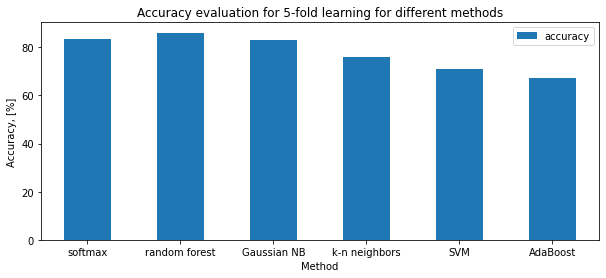

In [54]:
#fitting with all the methods at the same time and visualizing the accuracies
sample_evaluation = evaluation(feat,Y)

The highest accuracy is 86.67616421568627 for 23 number of trees


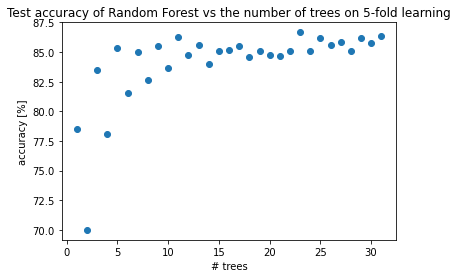

In [55]:
#huh, random forest looks good, let's see if we can fine-tune it so it's even better!
best_tree = best_forest(feat,Y,[1,31])

#given our simulations, the best accuracy is yielded with:
histogram + hu + haralick + canny

In [56]:
#let's check which numbers those are
feature_list()

,features
index,
0,histogram_feature
1,hsv_histogram_feature
2,hu_feature
3,haralick_feature
4,HOG_feature
5,canny_feature
6,SIFT_no_feature
7,LBP_feature


C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[array([79.36, 83.95, 61.99, 85.35, 82.56, 83.07]), array([82.37, 81.78, 70.86, 80.41, 79.85, 68.38]), array([78.63, 76.47, 38.39, 74.46, 73.09, 71.33]), array([64.51, 53.07, 35.8 , 58.69, 59.  , 53.71]), array([53.07, 38.93, 28.78, 48.94, 51.38, 32.4 ]), array([28.38, 10.12, 16.98, 21.92, 24.73, 14.4 ]), array([17.81,  2.42, 10.54, 11.63, 15.12,  6.29])]


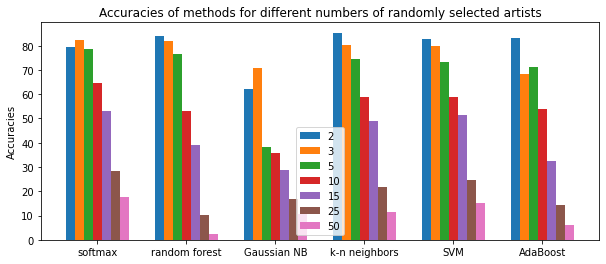

In [136]:
# randomly choosing 3, 5, then 7 artists, and comparing accuracies for all learning methods
# we choose to featurize the data with  the hisogram feature
graph_random([2,3, 5, 10, 15, 25, 50],path_to_folders, [0, 2, 3, 5])

In [59]:
#putting everything in the table
plot = [ [2,method_list()[1],93.22],[3, method_list()[1],82.15],[5, method_list()[0],73.85],[10, method_list()[3],60.92],[15, method_list()[3],50.16],[25, method_list()[0],35.54],[50,method_list()[0],22.10]]
df = pd.DataFrame(plot, columns = ['#artists','best method', 'accuracy'])
df

,#artists,best method,accuracy
0,2,random forest,93.22
1,3,random forest,82.15
2,5,softmax,73.85
3,10,k-n neighbors,60.92
4,15,k-n neighbors,50.16
5,25,softmax,35.54
6,50,softmax,22.10


# playground vol 2:
## we can now super easily choose the features we want and train on them

In [60]:
# let's see what features we have available
feature_list()

,features
index,
0,histogram_feature
1,hsv_histogram_feature
2,hu_feature
3,haralick_feature
4,HOG_feature
5,canny_feature
6,SIFT_no_feature
7,LBP_feature


C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

       method  accuracy
      softmax     84.40
random forest     90.28
  Gaussian NB     67.95
k-n neighbors     86.36
          SVM     86.52
     AdaBoost     86.13


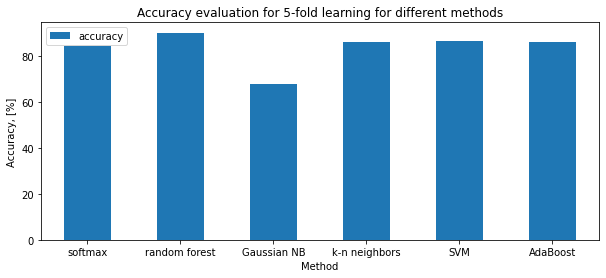

In [46]:
# awesome! how do our models perform on all these features together?
all_feats_together(data,Y)

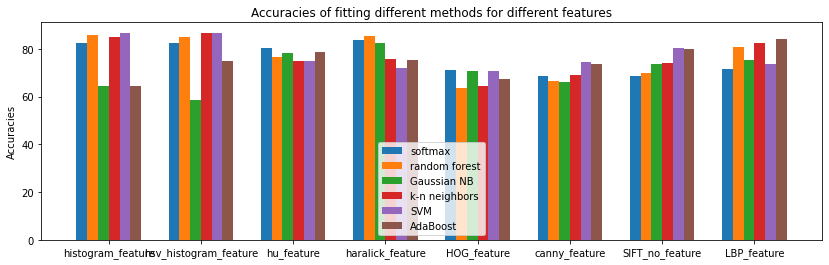

,softmax,random forest,Gaussian NB,k-n neighbors,SVM,AdaBoost
histogram_feature,82.37,85.89,64.58,85.03,86.52,64.42
hsv_histogram_feature,82.21,85.03,58.62,86.52,86.68,74.84
hu_feature,80.17,76.49,78.29,75.00,74.92,78.68
haralick_feature,83.54,85.35,82.37,75.55,72.10,75.25
HOG_feature,71.24,63.56,70.77,64.57,70.53,67.16
canny_feature,68.73,66.30,66.14,68.97,74.61,73.59
SIFT_no_feature,68.81,69.90,73.43,74.06,80.25,79.78
LBP_feature,71.47,80.80,75.32,82.60,73.74,84.17


In [45]:
# pretty neat, although the performance is not perfect
# how about each feature separately?
all_feats_fit(data,Y)

In [112]:
# what a cool comparison! the performance is not perfect either, although histogram and haralick are promising
# can we, by any chance combine only the features we want?
# of course! let's look at the features we have and their indicies
feature_list()

,features
index,
0,histogram_feature
1,hsv_histogram_feature
2,hu_feature
3,haralick_feature
4,HOG_feature
5,canny_feature
6,SIFT_no_feature
7,LBP_feature


In [63]:
# to combine various features together, we create a list that contains lists of indices of the features we want to use
# so, let's evaluate:
# - histogram + hu
# - hsv_histogram + haralick
# - histogram + canny + hog

#according to indices above:
desired_combinations = [[0, 2], [1, 3], [0, 4, 5]]

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


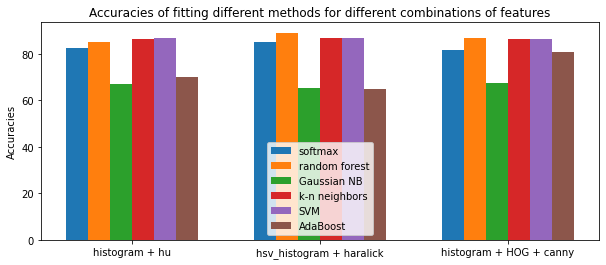

In [64]:
results = feats_fit(data, Y, desired_combinations)

In [65]:
#here's the crucial one - let's check the performance for all possible cominations of features
all_combinations = []
for i in range(1,9):
    combs = list(combinations([0,1,2,3,4,5,6,7],i))
    for j in range(len(combs)):
        all_combinations.append(list(combs[j]))

In [66]:
#how many are there in total?
len(all_combinations)

255

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\filip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

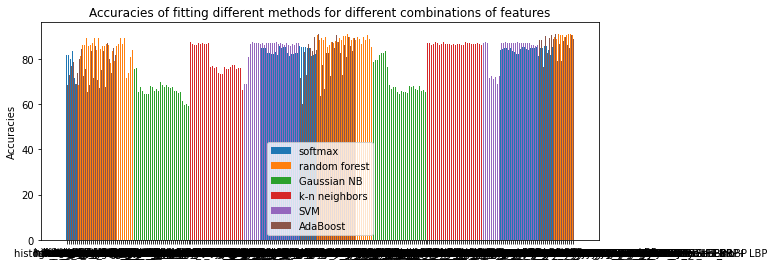

In [123]:
#let's now evaluate ALL these combinations of features
results = feats_fit(data, Y, all_combinations)

In [126]:
#let's print all these results here
pd.set_option("display.max_rows", None, "display.max_columns",None)
results

,softmax,random forest,Gaussian NB,k-n neighbors,SVM,AdaBoost
histogram,81.66,85.82,65.44,86.83,86.21,68.57
hsv_histogram,81.74,84.56,57.36,86.60,87.30,72.81
hu,80.10,76.88,78.45,75.55,74.76,76.88
haralick,83.46,85.42,82.44,76.41,72.18,78.45
HOG,71.32,63.17,70.61,63.88,70.85,68.89
canny,68.74,65.75,66.07,67.56,74.45,73.67
SIFT_no,68.73,68.49,73.75,74.45,79.94,79.94
LBP,71.39,81.19,75.23,82.53,73.83,84.25
histogram + hsv_histogram,82.45,85.89,64.11,86.21,87.30,72.26
histogram + hu,81.66,85.97,66.30,85.82,86.83,75.39


In [ ]:
results_np = results.to_numpy()
names = np.empty((0,6))

for i in range(len(all_combinations)):
    names = np.vstack((names,method_list()))

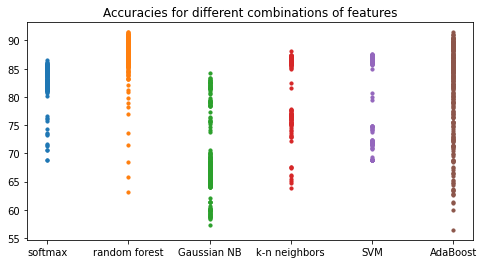

In [131]:
#a table seems good but let's plot all this now!
plt.scatter(names[:,0], results_np[:,0],s=10)
plt.scatter(names[:,1], results_np[:,1],s=10)
plt.scatter(names[:,2], results_np[:,2],s=10)
plt.scatter(names[:,3], results_np[:,3],s=10)
plt.scatter(names[:,4], results_np[:,4],s=10)
plt.scatter(names[:,5], results_np[:,5],s=10)
plt.title('Accuracies for different combinations of features')
plt.gcf().set_size_inches(8, 4)

In [67]:
# what if I just want to featurize with selected features and then do some stuff with it?
# we've got you covered!

# let's combine Haralick and HOG features; according to our list of features, they have indices 3 and 4, respectively
desired_features = [0, 2]
selected_featurizing = featurizing_sel(data,desired_features)

In [68]:
# that's quite a lot of features for using 2 features only!
selected_featurizing.shape

(1276, 31)

In [69]:
# what if I wanted to featurize using all the features
# (and I'm a little lazy to put down every index)
# use this function!
all_features = featurizing_all(data)

In [70]:
# there we go, all the features!
all_features.shape

(1276, 109)

In [71]:
# now we can obviously use some methods to check how they perform
# oh hey, we have some new ML methods!

#let's try SVM on all features
SVM(all_features, Y)

The average test accuracy over 5 -fold learning is : 86.51930147058825
The standard deviation is : 2.0152068435485004


(86.51930147058825, 2.0152068435485004)

In [72]:
# noice, that's decent

# there's another method though! that's supposed to be a killer; meet AdaBoost (it's a little slow though...)
#that's why we'll only do our selected features for demonstration

AdaBoost(selected_featurizing, Y)

The average test accuracy over 5 -fold learning is : 74.37837009803921
The standard deviation is : 4.776823433434701


(74.37837009803921, 4.776823433434701)

# CNN

In [78]:
#now let's tackle all this with CNN!
#for demonstration purposes, we'll do 2 artists only
path_to_folders = 'images/2/'

In [79]:
transform_image = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()]) 
dataset = datasets.ImageFolder(path_to_folders,transform=transform_image)

n = len(dataset)
n_test = int(0.1 * n) 

# Split data into features(pixels) and labels(numbers from 0 to 4)
train_dataset, test_dataset = random_split(dataset, (n-n_test,n_test))
train_loader, test_loader = DataLoader(train_dataset, batch_size=16, shuffle=True), DataLoader(test_dataset, batch_size=16, shuffle=True)



device = torch.cuda.is_available()
CUDA_LAUNCH_BLOCKING=1
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Quadro T1000 with Max-Q Design.......


In [80]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU() 
    self.Dropout1 = nn.Dropout(0.2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.batchnorm1 = nn.BatchNorm2d(10)     

    self.cnn2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1) 
    self.relu2 = nn.ReLU() 
    self.Dropout2 = nn.Dropout(0.2)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) 
    self.batchnorm2 = nn.BatchNorm2d(20)  

    self.cnn3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, stride=1, padding=1) 
    self.relu3 = nn.ReLU() 
    self.Dropout3 = nn.Dropout(0.2)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) 
    self.batchnorm3 = nn.BatchNorm2d(30)

    self.cnn4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, stride=1, padding=1)
    self.relu4 = nn.ReLU() 
    self.Dropout4 = nn.Dropout(0.2)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) 
    self.batchnorm4 = nn.BatchNorm2d(40)

    self.cnn5 = nn.Conv2d(in_channels=40, out_channels=45, kernel_size=3, stride=1, padding=1) 
    self.relu5 = nn.ReLU() 
    self.Dropout5 = nn.Dropout(0.2)
    self.maxpool5 = nn.MaxPool2d(kernel_size=2) 
    self.batchnorm5 = nn.BatchNorm2d(45)

    self.cnn6 = nn.Conv2d(in_channels=45, out_channels=50, kernel_size=3, stride=1, padding=1) 
    self.relu6 = nn.ReLU() 
    self.Dropout6 = nn.Dropout(0.2)
    self.maxpool6 = nn.MaxPool2d(kernel_size=2) 
    self.batchnorm6 = nn.BatchNorm2d(50)

    self.cnn7 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=3, stride=1, padding=1) 
    self.relu7 = nn.ReLU() 
    self.Dropout7 = nn.Dropout(0.2)
    self.maxpool7 = nn.MaxPool2d(kernel_size=2) 
    self.batchnorm7 = nn.BatchNorm2d(64)

    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
   #my_code
    # Fully connected 1
    self.fc1 = nn.Linear(64,1000) 
    self.fc2 = nn.Linear(1000,800)
    self.fc3 = nn.Linear(800,700)
    self.fc4 = nn.Linear(700,500)
    self.fc5 = nn.Linear(500,300)
    self.fc6 = nn.Linear(300,100)
    self.fc7 = nn.Linear(100,51)

  def forward(self,x):
    # TODO: Perform forward pass in blow section 
    # Example:
    out = self.cnn1(x)
    out = self.relu1(out) 
    out = self.Dropout1(out)
    out = self.maxpool1(out) 
    out = self.batchnorm1(out)
    
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.Dropout2(out)
    out = self.maxpool2(out) 
    out = self.batchnorm2(out)
    
    out = self.cnn3(out)
    out = self.relu3(out)
    out = self.Dropout3(out)
    out = self.maxpool3(out) 
    out = self.batchnorm3(out)

    out = self.cnn4(out)
    out = self.relu4(out)
    out = self.Dropout4(out)
    out = self.maxpool4(out)
    out = self.batchnorm4(out)

    out = self.cnn5(out)
    out = self.relu5(out)
    out = self.Dropout5(out)
    out = self.maxpool5(out)
    out = self.batchnorm5(out)

    out = self.cnn6(out)
    out = self.relu6(out)
    out = self.Dropout6(out)
    out = self.maxpool6(out)
    out = self.batchnorm6(out)

    out = self.cnn7(out)
    out = self.relu7(out)
    out = self.Dropout7(out)
    out = self.maxpool7(out)
    out = self.batchnorm7(out)
      
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.fc4(out)
    out = self.fc5(out)
    out = self.fc6(out)
    out = self.fc7(out)
    
    return out

In [81]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)
summary(model,(3,224,224))
torch.Size()
# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 1e-4
optimizer = Adam(model.parameters(),learning_rate)

num_epochs = 15

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 224, 224]             280
              ReLU-2         [-1, 10, 224, 224]               0
           Dropout-3         [-1, 10, 224, 224]               0
         MaxPool2d-4         [-1, 10, 112, 112]               0
       BatchNorm2d-5         [-1, 10, 112, 112]              20
            Conv2d-6         [-1, 20, 112, 112]           1,820
              ReLU-7         [-1, 20, 112, 112]               0
           Dropout-8         [-1, 20, 112, 112]               0
         MaxPool2d-9           [-1, 20, 56, 56]               0
      BatchNorm2d-10           [-1, 20, 56, 56]              40
           Conv2d-11           [-1, 30, 56, 56]           5,430
             ReLU-12           [-1, 30, 56, 56]               0
          Dropout-13           [-1, 30, 56, 56]               0
        MaxPool2d-14           [-1, 30,

In [82]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(images)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs,labels)
        
        # Backpropagate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

 53%|████████████████████████████████████████████▎                                      | 8/15 [02:31<02:16, 19.53s/it]

Iteration: 500  Loss: 0.25325915217399597  Accuracy: 89.1089096069336 %


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:52<00:00, 19.51s/it]


In [102]:
#here we have all the accuracies across each epoch
accuracy_list

[tensor(47.5248, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(92.0792, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(94.0594, device='cuda:0'),
 tensor(89.1089, device='cuda:0'),
 tensor(88.1188, device='cuda:0'),
 tensor(89.1089, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(89.1089, device='cuda:0'),
 tensor(98.0198, device='cuda:0'),
 tensor(87.1287, device='cuda:0'),
 tensor(90.0990, device='cuda:0')]

In [103]:
#now that's pretty awesome - 98.02% in one of the iterations!
#is CNN promising? well, here is comparison from all our tests!

In [135]:
#here, we'll put the results from playground 1 and our external CNN simulations
labels = [str(2), str(3), str(5), str(10), str(15), str(25), str(50)]
types = ['shallow ML','CNN']
cols = ['artistNo','shallowML','CNN']
accuracies = []
acc_ML = [93.22,82.15,73.85,60.92,50.16,35.54,22.1]
acc_CNN = [92.08,90.57,80.13,70.83,61.19, 48.65, 40.28]
acc = np.column_stack((np.array(acc_ML),np.array(acc_CNN)))
acc = np.column_stack((labels,acc))
acc = pd.DataFrame(acc, columns = cols)
acc.style.set_caption("Accuracies")

,artistNo,shallowML,CNN
0,2,93.22,92.08
1,3,82.15,90.57
2,5,73.85,80.13
3,10,60.92,70.83
4,15,50.16,61.19
5,25,35.54,48.65
6,50,22.1,40.28


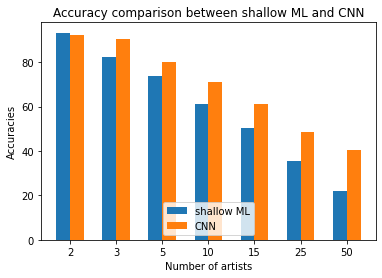

In [136]:
#let's also plot everything so it's a little easier to compare
acc = np.array([list(acc.shallowML),list(acc.CNN)])
acc_form = np.empty(np.shape(acc))
for i in range(len(acc)):
    for j in range(len(acc[i])):
        acc_form[i,j] = float(acc[i,j])
labels_no = len(types)
ind = np.linspace(0,len(labels),len(labels))
width = 0.7/labels_no

for i in range(labels_no):
    plt.bar(ind + width*(i+1)-0.35, acc_form[i], width, label=types[i])

plt.ylabel('Accuracies')
plt.xlabel('Number of artists')

plt.title('Accuracy comparison between shallow ML and CNN')
plt.legend(loc='lower center')    

plt.xticks(ind + width / 2, labels)
plt.gcf().set_size_inches(6, 4)
plt.show()